Following the method outlined in http://ai.stanford.edu/~ang/papers/nips02-metric.pdf

First generate some fake data:

In [98]:
%matplotlib inline

import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt

In [99]:
N = 200

x1 = np.random.normal(1,1,N)
y1 = np.random.normal(1,1,N)

x2 = np.random.normal(10,1,N)
y2 = np.random.normal(1,1,N)

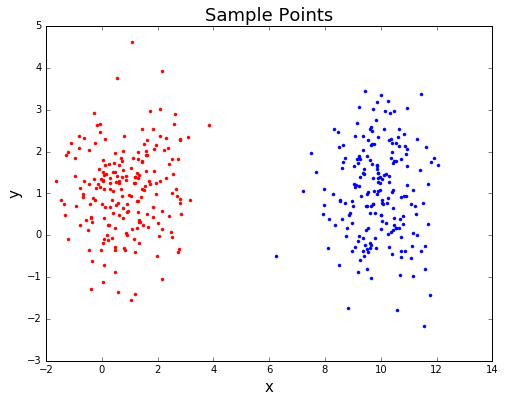

In [100]:
fig = plt.figure()
plt.plot(x1,y1,'r.')
plt.plot(x2,y2,'b.')
plt.title("Sample Points",size = 18)
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)
fig.set_size_inches(8, 6)

Define the function to be minimized:

In [101]:
def J(theta):
    function = 0
    for i in range(len(x1)):
        for j in range(len(x2)):
            function += ( theta[0]*(x1[i]-x1[j])**2 + theta[1]*(y1[i]-y1[j])**2 +
                         theta[0]*(x2[i]-x2[j])**2 + theta[1]*(y2[i]-y2[j])**2 )
    constraint = 0
    for i in range(len(x1)):
        j = np.random.randint(0,len(x1)-1)
        constraint += abs(theta[0]*(x1[i]-x2[j])) + abs(theta[1]*(y1[i]-y2[j]))
    
    return function + np.log(constraint)    


In [102]:
def theta1(theta):
    return theta[0]

def theta2(theta):
    return theta[1]

In [103]:
cons = [{'type': 'ineq', 'fun': theta1}, {'type': 'ineq', 'fun': theta2}]

bnds = [(0,None),(0,None)]

In [106]:
theta_init = np.random.random(2)
opt = optimize.minimize(fun=J,x0=theta_init,bounds=bnds,constraints=cons)
theta_min = opt.x
theta_min = theta_min/max(theta_min)
theta_min

array([ 1.        ,  0.40071148])

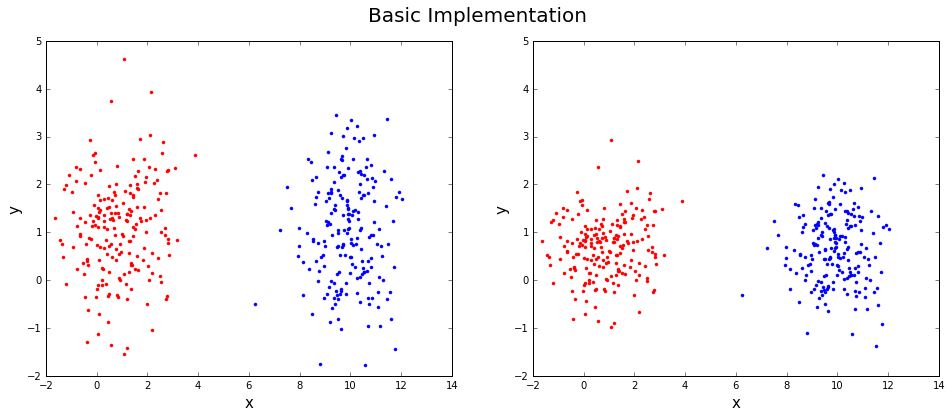

In [158]:
fig = plt.figure()

plt.subplot(121)
plt.plot(x1,y1,'r.')
plt.plot(x2,y2,'b.')
plt.xlim(-2,14)
plt.ylim(-2,5)
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)

plt.subplot(122)
plt.plot(np.sqrt(theta_min[0])*x1,np.sqrt(theta_min[1])*y1,'r.')
plt.plot(np.sqrt(theta_min[0])*x2,np.sqrt(theta_min[1])*y2,'b.')
plt.xlim(-2,14)
plt.ylim(-2,5)
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)

plt.suptitle("Basic Implementation",size=20)

fig.set_size_inches(16, 6)

Now try with the Large Margin Nearest Neighbor (LMNN), Least Squares Metric Learning (LSML), and Neighborhood Components Analysis (NCA) algorithms https://all-umass.github.io/metric-learn/metric_learn.lmnn.html

In [182]:
from metric_learn import LMNN, LSML_Supervised, NCA

In [152]:
X = np.vstack( (np.hstack((x1,x2)) , np.hstack((y1,y2))) )
X = np.transpose(X)

Y = np.hstack( (np.zeros(N),np.ones(N)) )

In [186]:
lmnn = LMNN(k=2, learn_rate=1e-6)
lmnn_metric=np.matrix(lmnn.fit(X,Y).metric())
lmnn_metric

matrix([[ 0.08792128, -0.03826702],
        [-0.03826702,  0.02235781]])

In [187]:
X_transform = lmnn_metric * np.transpose(np.matrix(X))

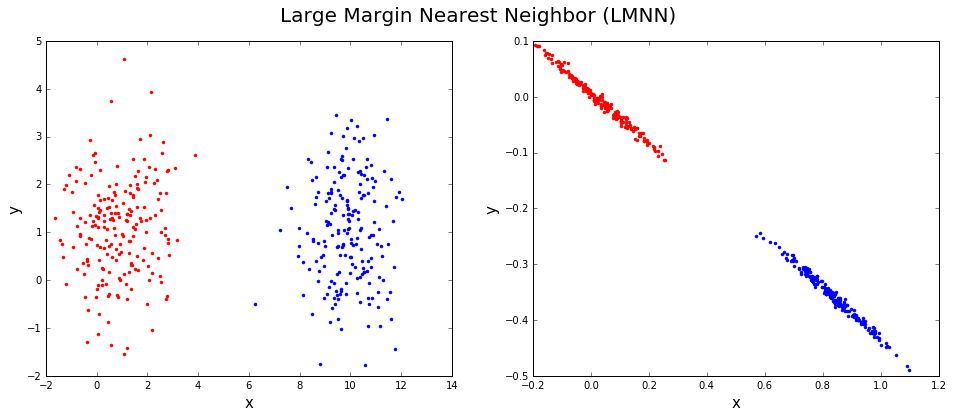

In [188]:
fig = plt.figure()

plt.subplot(121)
plt.plot(x1,y1,'r.')
plt.plot(x2,y2,'b.')
plt.xlim(-2,14)
plt.ylim(-2,5)
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)

plt.subplot(122)
plt.plot(X_transform[0,0:N-1],X_transform[1,0:N-1],'r.')
plt.plot(X_transform[0,N:],X_transform[1,N:],'b.')
#plt.xlim(-2,14)
#plt.ylim(-2,5)
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)

plt.suptitle("Large Margin Nearest Neighbor (LMNN)",size=20)

fig.set_size_inches(16, 6)

In [189]:
lsml = LSML_Supervised(num_constraints=200)
lsml_metric = np.matrix(lsml.fit(X,Y).metric())
lsml_metric

matrix([[ 21.50650425,  -0.08767491],
        [ -0.08767491,   1.1265378 ]])

In [191]:
X_transform = lsml_metric * np.transpose(np.matrix(X))

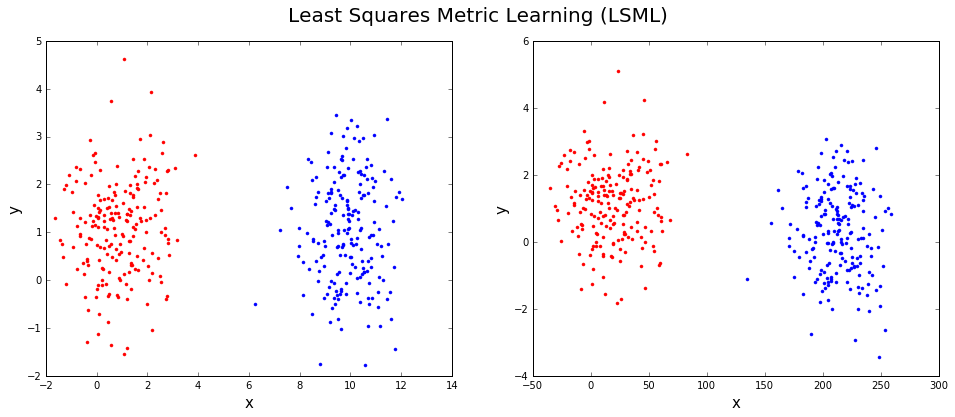

In [192]:
fig = plt.figure()

plt.subplot(121)
plt.plot(x1,y1,'r.')
plt.plot(x2,y2,'b.')
plt.xlim(-2,14)
plt.ylim(-2,5)
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)

plt.subplot(122)
plt.plot(X_transform[0,0:N-1],X_transform[1,0:N-1],'r.')
plt.plot(X_transform[0,N:],X_transform[1,N:],'b.')
#plt.xlim(-2,14)
#plt.ylim(-2,5)
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)

plt.suptitle("Least Squares Metric Learning (LSML)",size=20)

fig.set_size_inches(16, 6)

In [193]:
nca = NCA(max_iter=1000, learning_rate=0.01)
nca_metric = np.matrix(nca.fit(X, Y).metric())

In [194]:
X_transform = nca_metric * np.transpose(np.matrix(X))

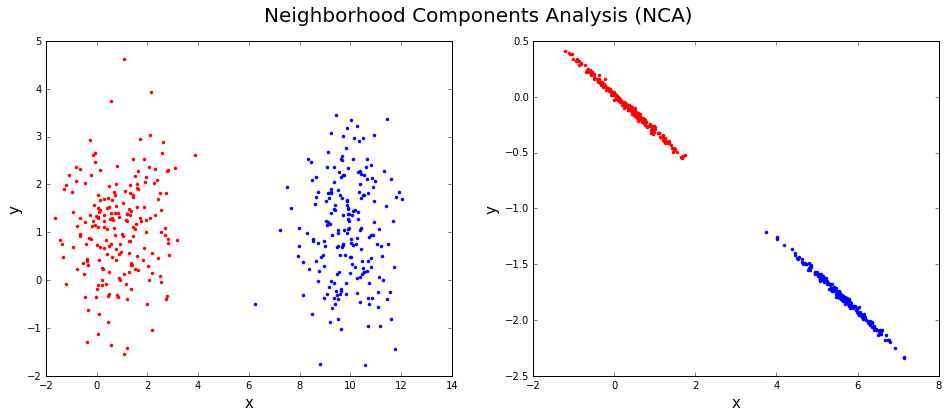

In [195]:
fig = plt.figure()

plt.subplot(121)
plt.plot(x1,y1,'r.')
plt.plot(x2,y2,'b.')
plt.xlim(-2,14)
plt.ylim(-2,5)
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)

plt.subplot(122)
plt.plot(X_transform[0,0:N-1],X_transform[1,0:N-1],'r.')
plt.plot(X_transform[0,N:],X_transform[1,N:],'b.')
#plt.xlim(-2,14)
#plt.ylim(-2,5)
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)

plt.suptitle("Neighborhood Components Analysis (NCA)",size=20)

fig.set_size_inches(16, 6)